# COVID-19 HERD CALCULATOR

###  Set-Up for Forecasting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..') # only run once - I need to improve how we handle these relative paths, but this will work for now

In [4]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics

import sys
sys.path.insert(1,'../yyg-seir-simulator')

import run_simulation

In [5]:
cd yyg-seir-simulator

/Users/mauriceburger/yyg-seir-simulator


### Run Youyang Gu's SEIR infection simulation for Philadelphia

In [6]:
!python run_simulation.py -v --best_params_dir best_params/latest --country US --region PA --subregion "Philadelphia" --simulation_end_date 2020-10-31  --save_csv_fname philadelphia_simulation.csv

YYG/C19PRO Simulator
Current time: 2021-01-19 12:25:18.208039
Loading params file: best_params/latest/subregion/US_PA_Philadelphia.json
best params type: mean
US | PA | Philadelphia
Parameters:
INITIAL_R_0               : 3.786765484922743
LOCKDOWN_R_0              : 0.862126469543858
INFLECTION_DAY            : 2020-03-16
RATE_OF_INFLECTION        : 0.38090896211990627
LOCKDOWN_FATIGUE          : 1.0
DAILY_IMPORTS             : 341.0675605457681
MORTALITY_RATE            : 0.010000000000000002
REOPEN_DATE               : 2020-06-15
REOPEN_SHIFT_DAYS         : -0.17785118910400016
REOPEN_R                  : 1.1030124623303692
REOPEN_INFLECTION         : 0.2987461710903824
POST_REOPEN_EQUILIBRIUM_R : 0.9755569564839857
FALL_R_MULTIPLIER         : 1.0021399641171804
--------------------------
Running simulation...
--------------------------
1   - 2020-03-01 - New / total infections: 341 / 341 - Hospital beds in use: 0 - New / total deaths: 0.00 / 0.0 - Mean R: 3.787 - IFR: 1.00%
2   - 2

### Create a DataFrame using the generated csv file

In [7]:
df = pd.read_csv('philadelphia_simulation.csv')
df.iloc[[*range(5), *range(-5, 0)]]

,# dates,infections,hospitalizations,deaths,mean_r_t
0,2020-03-01,341.067561,0.0,0.000000,3.786765
1,2020-03-02,341.067561,0.0,0.000000,3.772705
2,2020-03-03,341.067561,0.0,0.000000,3.766232
3,2020-03-04,341.067561,0.0,0.000000,3.756810
4,2020-03-05,341.067561,0.0,0.000000,3.743129
240,2020-10-27,1031.936540,159.0,2.023139,1.105808
241,2020-10-28,1056.373420,162.0,2.050559,1.108195
242,2020-10-29,1081.804261,165.0,2.079300,1.110575
243,2020-10-30,1108.270856,168.0,2.109401,1.112948
244,2020-10-31,1135.817066,171.0,2.140906,1.115315


In [8]:
df.describe()

,infections,hospitalizations,deaths,mean_r_t
count,245.000000,245.000000,245.000000,245.000000
mean,1293.473522,268.889796,7.398696,1.117750
std,1181.479869,263.673062,8.686049,0.632598
min,341.067561,0.000000,0.000000,0.823261
25%,550.514291,120.000000,1.677064,0.837014
50%,654.676814,133.000000,2.079300,0.973351
75%,1641.106952,362.000000,11.794712,1.046020
max,4649.927179,985.000000,27.738627,3.786765


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   # dates           245 non-null    object 
 1   infections        245 non-null    float64
 2   hospitalizations  245 non-null    float64
 3   deaths            245 non-null    float64
 4   mean_r_t          245 non-null    float64
dtypes: float64(4), object(1)
memory usage: 9.7+ KB


### Prepare DataFrame for forecasting

In [10]:
df = df.drop(columns=['hospitalizations', 'deaths' , 'mean_r_t'])

### Set up Facebook Prophet forecasting model

In [11]:
!pip install fbprophet

In [12]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [13]:
df.columns = ['ds', 'y']
m = Prophet(yearly_seasonality=False)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
605,2021-10-27
606,2021-10-28
607,2021-10-29
608,2021-10-30
609,2021-10-31


### Forecast infection rates using Facebook prophet model

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
605,2021-10-27,387.902382,-2970.122987,3632.482559
606,2021-10-28,392.888061,-2782.104507,3575.598510
607,2021-10-29,401.552955,-2852.186615,3590.590289
608,2021-10-30,414.774987,-2821.740430,3705.970350
609,2021-10-31,344.108815,-2825.290183,3598.849917


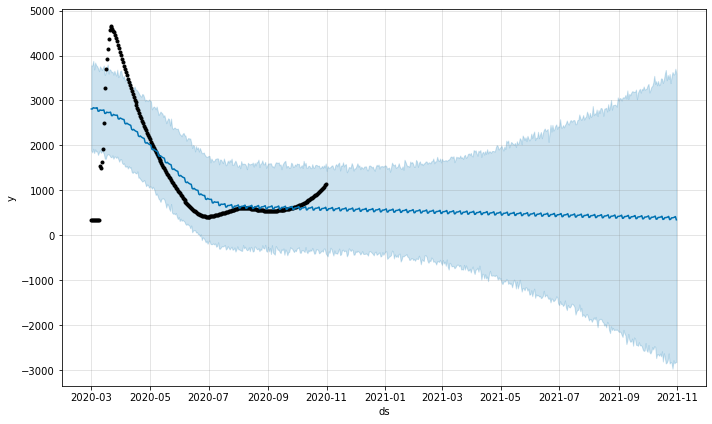

In [16]:
fig1 = m.plot(forecast)

### Integrate dataset with newest case numbers from Philadelphia

In [20]:
df_new_data = pd.read_csv('covid_cases_by_date.csv')
df_new_data = df_new_data[df_new_data.test_result != 'negative']
df_new_data = df_new_data.drop(columns = ['the_geom','the_geom_webmercator', 'test_result'])
df_new_data['collection_date'] = pd.to_datetime(df_new_data.collection_date)
df['ds'] = pd.to_datetime(df.ds)
df_new_data = df_new_data.sort_values(by='collection_date')
df_new_data
df_new_data.columns = ['ds', 'positive_tests']

In [21]:
df = pd.read_csv('philadelphia_simulation.csv')
df = df.drop(columns=['hospitalizations', 'deaths', 'mean_r_t'])
df.columns = ['ds', 'infections']
df['ds'] = pd.to_datetime(df.ds)
df = pd.merge(df, df_new_data)
df

,ds,infections,positive_tests
0,2020-03-04,341.067561,524
1,2020-03-05,341.067561,138
2,2020-03-06,341.067561,145
3,2020-03-07,341.067561,97
4,2020-03-08,341.067561,144
...,...,...,...
216,2020-10-27,1031.936540,402
217,2020-10-28,1056.373420,490
218,2020-10-29,1081.804261,450
219,2020-10-30,1108.270856,531


### Run linear regression model on positive tests to predict infections for full set of dates

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib notebook

In [23]:
# test train split for supervised training
X_train, X_test, y_train, y_test = train_test_split(df.positive_tests, df.infections)

<IPython.core.display.Javascript object>


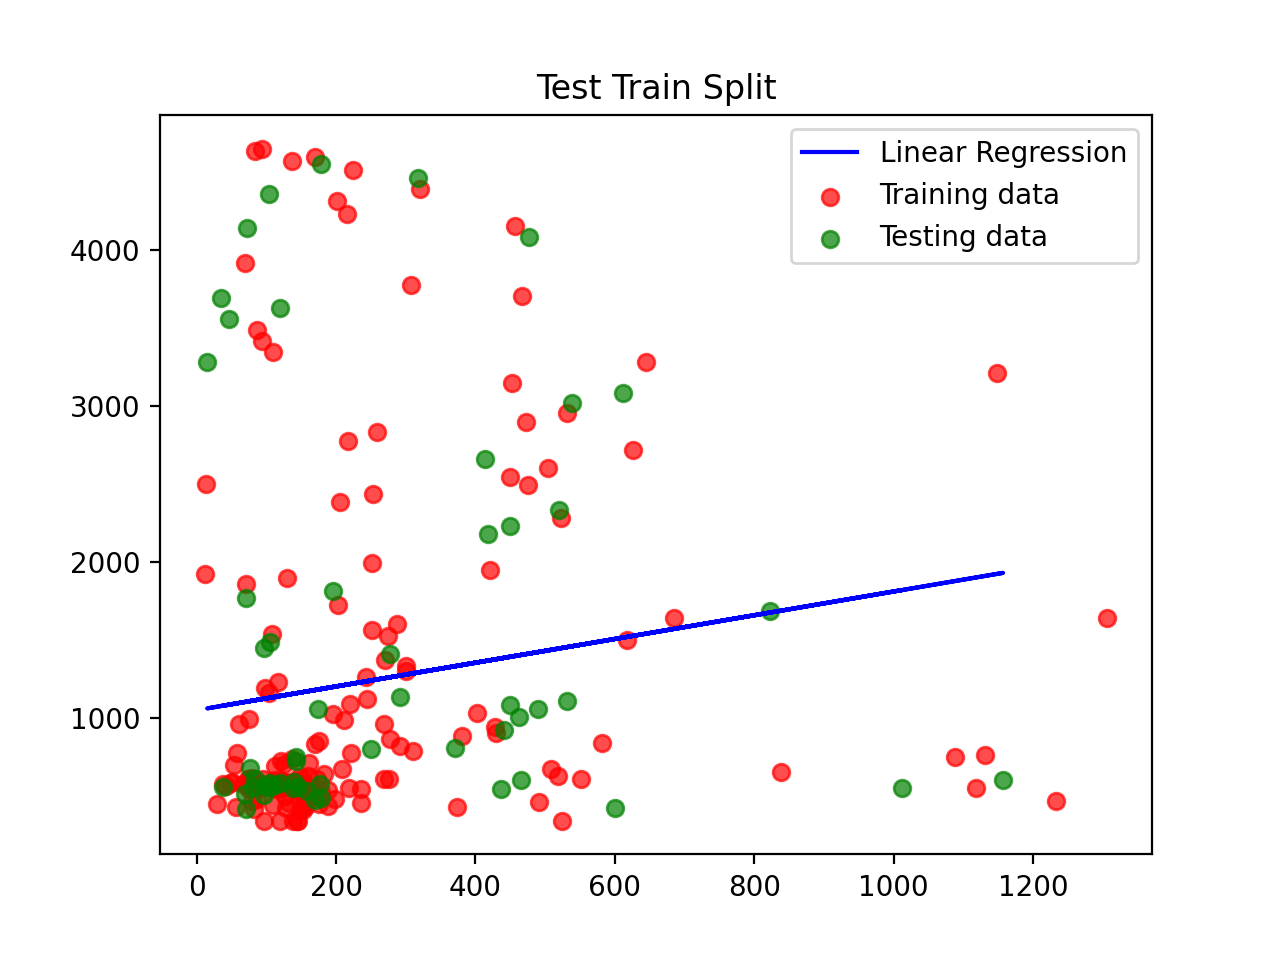

In [24]:
# test train split visualization
plt.scatter(X_train, y_train, label = 'Training data', color = 'r', alpha =.7)
plt.scatter(X_test, y_test, label = 'Testing data', color = 'g', alpha =.7)
plt.legend()
plt.title('Test Train Split')
plt.show()

In [25]:
# create linear model
LR = LinearRegression()
LR.fit(X_train.values.reshape(-1,1), y_train.values)


LinearRegression()

In [26]:
# use model to predict on Test data
prediction = LR.predict(X_test.values.reshape(-1,1))

# plot prediction line against actual test data
plt.plot(X_test, prediction, label='Linear Regression', color = 'b')
plt.legend()
plt.show()

In [27]:
# score this model
LR.score(X_test.values.reshape(-1,1), y_test.values)

-0.06731746799544669

In [28]:
prediction

array([1123.47486152, 1820.49026515, 1423.28279714, 1109.01711843,
       1124.99672921, 1160.76062001, 1676.67376811, 1385.99703865,
       1128.80139844, 1382.95330326, 1401.97664943, 1185.1105031 ,
       1112.06085381, 1240.65867392, 1179.02303233, 1930.82567293,
       1079.3406984 , 1086.18910302, 1185.87143695, 1182.82770156,
       1105.21244919, 1158.47781847, 1261.20388778, 1392.84544327,
       1506.98552029, 1271.85696164, 1392.08450942, 1331.97073553,
       1061.83921993, 1130.32326614, 1198.80731235, 1141.73727384,
       1454.48108486, 1135.64980306, 1185.87143695, 1129.56233229,
       1292.4021755 , 1404.25945097, 1155.43408308, 1459.80762179,
       1515.3557926 , 1413.39065713, 1103.6905815 , 1140.97633999,
       1102.92964765, 1368.49556017, 1130.32326614, 1114.34365536,
       1170.65276002, 1156.95595077, 1077.05789686, 1103.6905815 ,
       1159.23875231, 1365.45182479, 1123.47486152, 1446.11081254])

In [29]:
# use this model to predict for all dates
full_prediction = LR.predict(df_new_data.positive_tests.values.reshape(-1,1))
df_new_data = df_new_data.append(dict(zip(df_new_data.columns, full_prediction)), ignore_index=True)
df_new_data

,ds,positive_tests
0,2020-01-04 00:00:00,446.000000
1,2020-01-05 00:00:00,332.000000
2,2020-01-06 00:00:00,108.000000
3,2020-01-07 00:00:00,176.000000
4,2020-01-08 00:00:00,64.000000
...,...,...
305,2021-09-01 00:00:00,378.000000
306,2021-10-01 00:00:00,259.000000
307,2021-11-01 00:00:00,654.000000
308,2021-12-01 00:00:00,448.000000


In [30]:
# append all predictions to the original dataset


# Vaccination Predictions

In [31]:
df_vaccines = pd.read_csv('Prof.csv')
df_vaccines.columns = ['ds', 'y']
df_vaccines

,ds,y
0,16.12.20,1106
1,17.12.20,2634
2,18.12.20,5535
3,19.12.20,6808
4,20.12.20,7487
5,21.12.20,9843
6,22.12.20,12229
7,23.12.20,14453
8,24.12.20,14999
9,25.12.20,14999


In [32]:
n = Prophet()
n.fit(df_vaccines)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [33]:
vaccine_future = n.make_future_dataframe(periods=365)
vaccine_future.tail()

,ds
390,2022-11-27
391,2022-11-28
392,2022-11-29
393,2022-11-30
394,2022-12-01


In [34]:
vaccine_forecast = n.predict(vaccine_future)
vaccine_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
390,2022-11-27,96414.607602,81294.952268,111258.482614
391,2022-11-28,99594.775991,84960.663051,113752.534481
392,2022-11-29,99790.714354,84837.601616,114323.481850
393,2022-11-30,104248.032397,89913.192924,118550.233334
394,2022-12-01,105700.573610,90908.412179,120704.122267


<IPython.core.display.Javascript object>


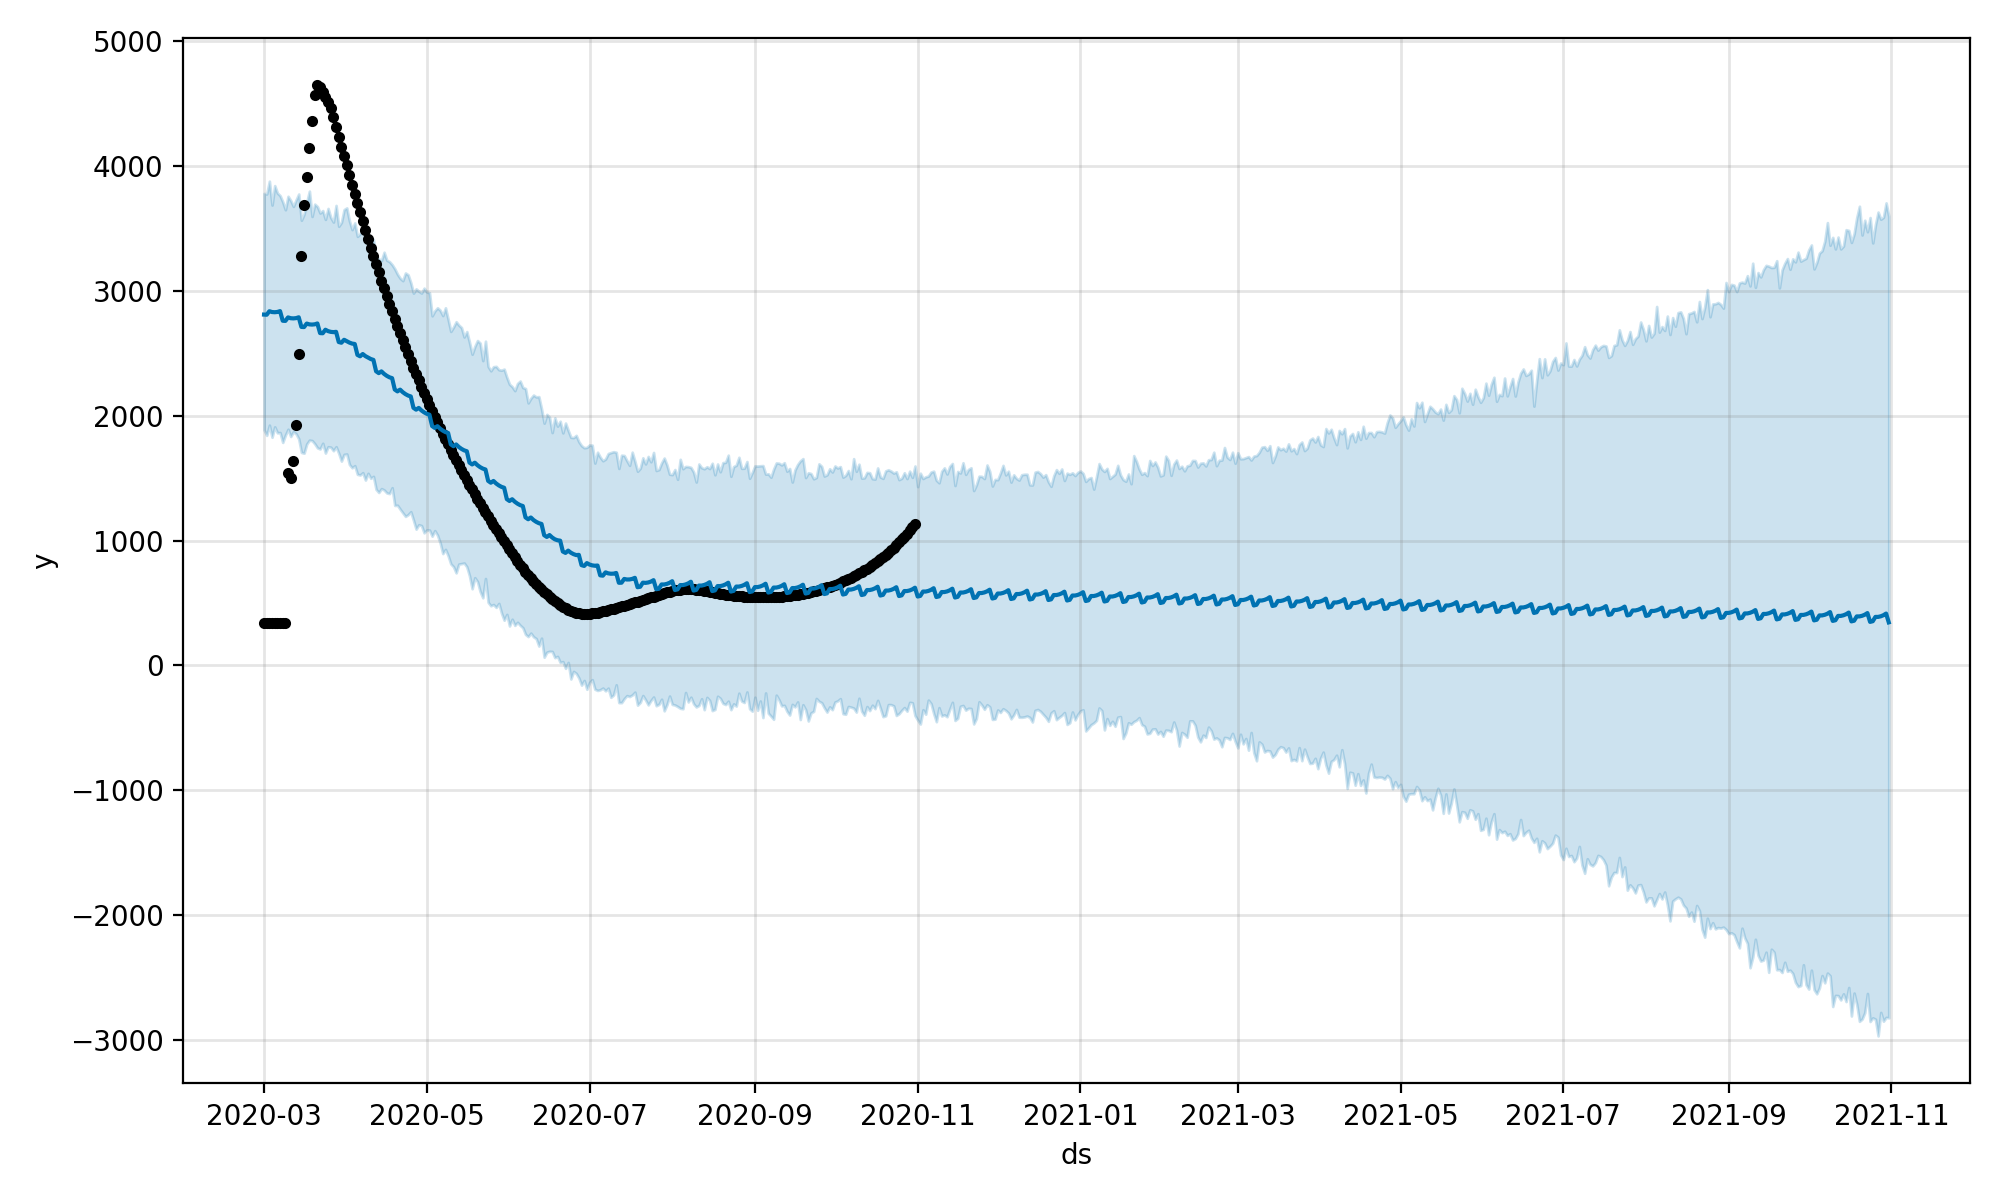

<IPython.core.display.Javascript object>


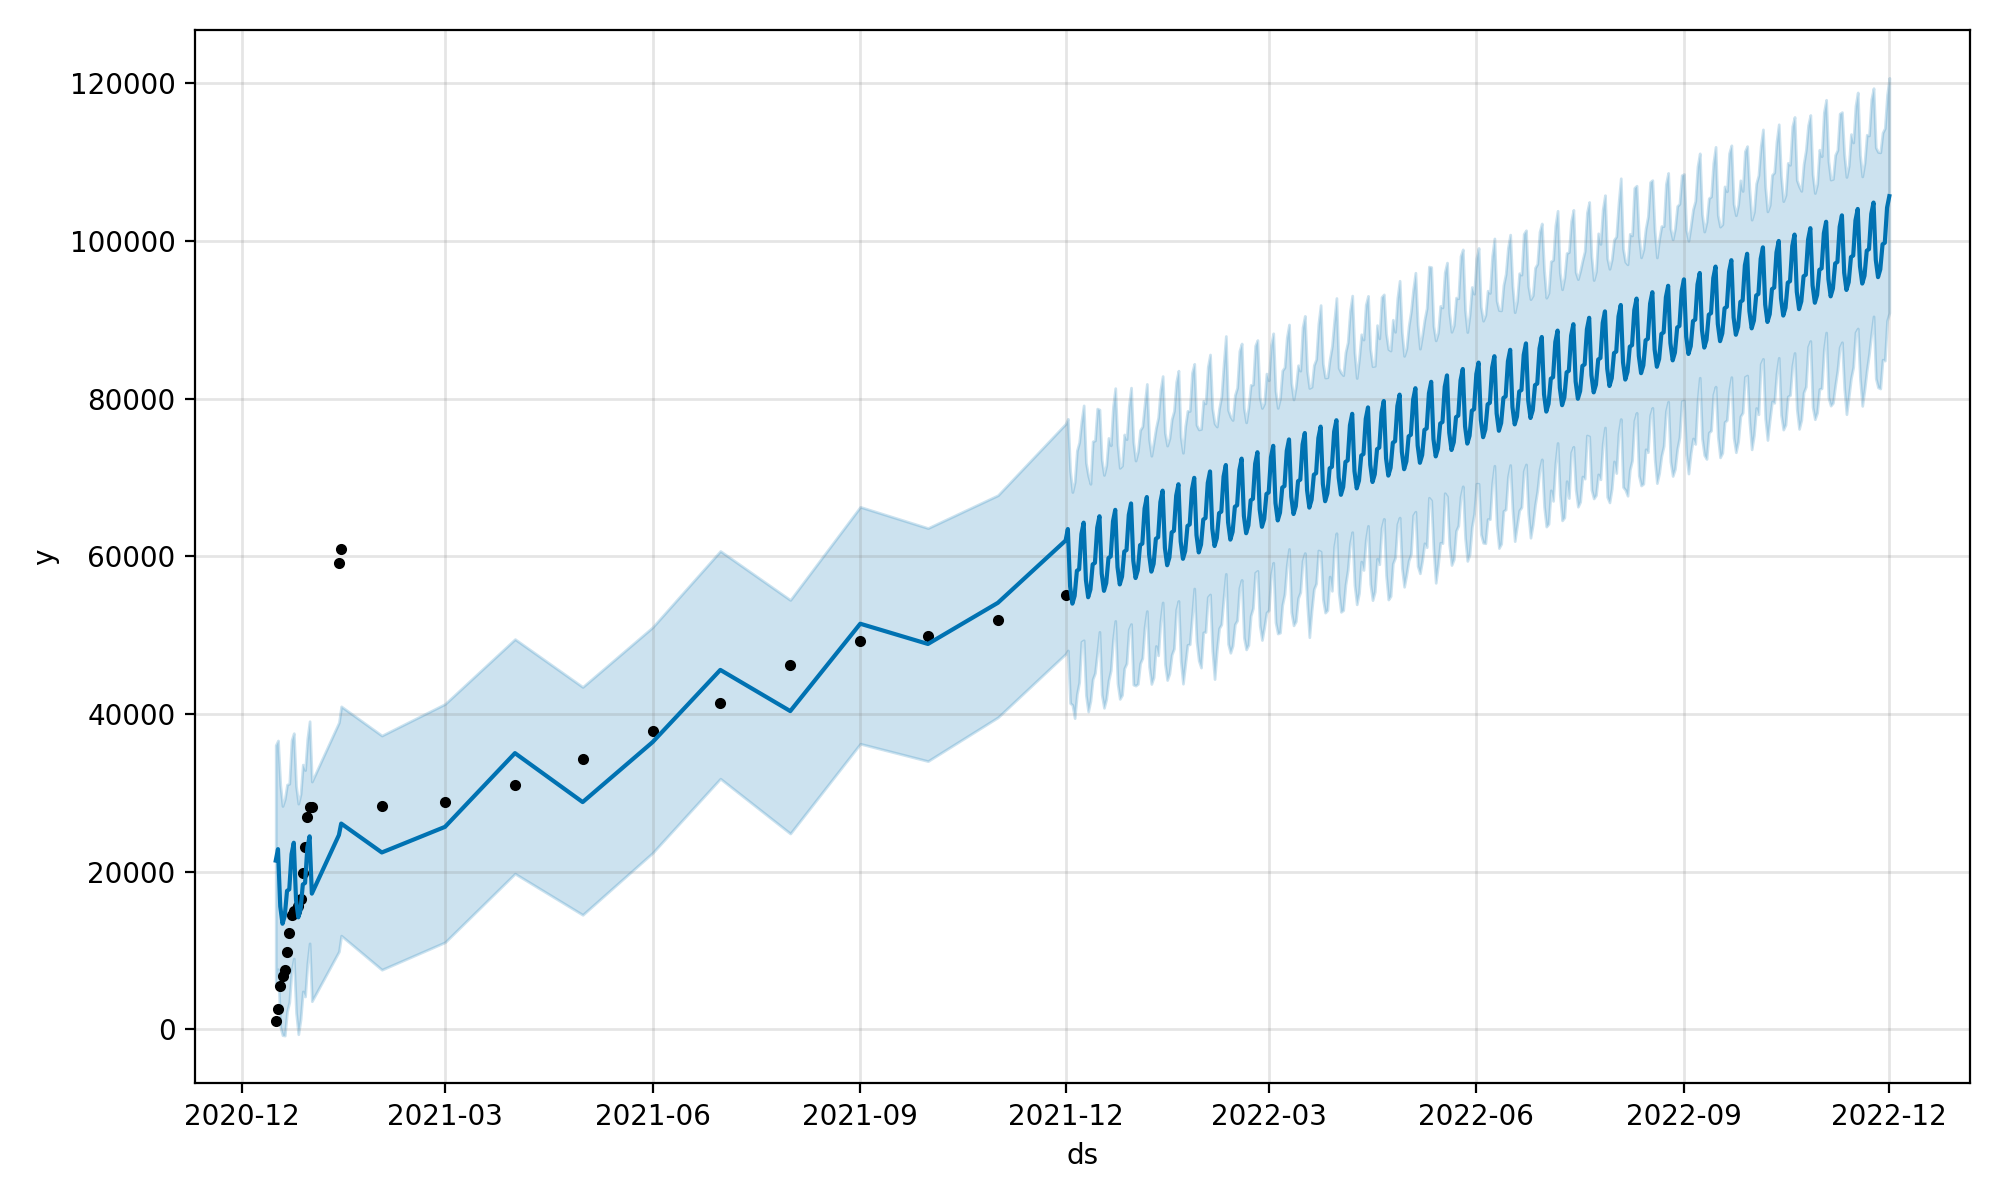

In [35]:
# print infection and vaccination projections
fig1 = m.plot(forecast)
fig2 = n.plot(vaccine_forecast)